Foram testadas duas situações. Um modelo de rede neural pré-treinado e uma cnn desenvolvida desde o inicio, com todos blocos de camadas convolucionais. Há necessidade, no entanto, de mais tempo de estudo para lidar com a pequenena quantidade de imagens para treinar, validar e testar. 

In [4]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from random import shuffle
from keras.models import Sequential
from keras.models import load_model,Model
from keras.layers import Dense,Dropout, Activation, Flatten,Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.callbacks import TensorBoard, EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from keras.applications.mobilenet import MobileNet
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay

A função abaixo carrega os dados específicos para este dataset (BMW-10)

In [5]:
def load_data(datadir, img_size=200):

    training_data = []
    label = []
    for category in range(3,6):
        path = os.path.join(datadir, str(category))
        class_num = category - 3
        shufled_list  = list(os.listdir(path))
        shuffle(shufled_list)

        for img in shufled_list:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            img_array = cv2.resize(img_array, (img_size, img_size))
            training_data.append(img_array)
            label.append(class_num)


    return training_data , label

O bloco de funções seguintes gera o conjunto de validação, treino e teste.

In [7]:
def generate_normalized_array(X):
    X = np.array(X)
    X = (X / 255).astype(np.float16)
    return X


def train_val_test_split(X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
    X_train = generate_normalized_array(X_train)
    X_val = generate_normalized_array(X_val)
    X_test = generate_normalized_array(X_test)
    return X_train,np.array(y_train),X_val,np.array(y_val),X_test,np.array(y_test)

img_size = 100
training_data, label = load_data('/content/dataset', img_size)
X_train,y_train,X_val,y_val,X_test,y_test = train_val_test_split(training_data,label)
print("[INFO] training data has ",len(X_train)," samples")
print("[INFO] validation data has ",len(X_val)," samples")
print("[INFO] test data has ",len(X_test)," samples")


[INFO] training data has  84  samples
[INFO] validation data has  21  samples
[INFO] test data has  46  samples


O Bloco de funções seguintes gera um modelo de CNN básico criado desde o início.

In [8]:
def gen_model(X_train,y_train,X_val,y_val,output_path,model_name='cnn_car_classifier'):
    
    model_file = os.path.join(output_path,model_name)
    model = Sequential()
    model.add(Conv2D(256, kernel_size=(3, 3), input_shape=X_train.shape[1:],padding='same'))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.1))
    model.add(Conv2D(256, kernel_size=(3,3),padding='same'))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.1))
    model.add(Conv2D(128, kernel_size=(3, 3),padding='same'))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(3))
    model.add(Activation('softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['sparse_categorical_accuracy'])
    earlyStopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1, mode='min')
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=40, verbose=1,
                                       epsilon=1e-4,
                                       mode='min')
    mcp_save = ModelCheckpoint(model_file +'.h5', save_best_only=True, monitor='val_loss',
                               mode='min')
    print(model.summary())

    model.fit(X_train, y_train, batch_size=8, epochs=200, validation_data=(X_val, y_val), shuffle=True,callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

gen_model(X_train,y_train,X_val,y_val,'')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 256)     7168      
                                                                 
 activation (Activation)     (None, 100, 100, 256)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 50, 50, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 256)       590080    
                                                                 
 activation_1 (Activation)   (None, 50, 50, 256)       0         
                                                        

O bloco de funções seguintes treina somente as camadas densas da mobileNet

In [9]:
def generate_mobile_network(X_train,y_train,X_val,y_val,output_path,model_name='mobile_car_classifier'):

    model_file = os.path.join(output_path,model_name)
    base_model = MobileNet(input_shape=(100,100,3), include_top=False, weights='imagenet')

    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(3)(x)
    x = Activation('softmax')(x)
    model = Model(base_model.input, x)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['sparse_categorical_accuracy'])

    earlyStopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1, mode='min')
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=40, verbose=1,
                                       epsilon=1e-4,
                                       mode='min')
    mcp_save = ModelCheckpoint(model_file +'.h5', save_best_only=True, monitor='val_loss',
                               mode='min')
    model.fit(X_train, y_train, batch_size=8, epochs=200, validation_data=(X_val, y_val), shuffle=True,
              callbacks=[earlyStopping, mcp_save, reduce_lr_loss])
    
generate_mobile_network(X_train,y_train,X_val,y_val,'')

17235968/17225924 [==============================] - 0s 0us/step
Epoch 1/200
11/11 [==============================] - 3s 102ms/step - loss: 1.8257 - sparse_categorical_accuracy: 0.3571 - val_loss: 2.0283 - val_sparse_categorical_accuracy: 0.3810 - lr: 0.0010
Epoch 2/200
11/11 [==============================] - 0s 9ms/step - loss: 1.4582 - sparse_categorical_accuracy: 0.4405 - val_loss: 2.2835 - val_sparse_categorical_accuracy: 0.2857 - lr: 0.0010
Epoch 3/200
11/11 [==============================] - 0s 26ms/step - loss: 0.9087 - sparse_categorical_accuracy: 0.6190 - val_loss: 1.7279 - val_sparse_categorical_accuracy: 0.3810 - lr: 0.0010
Epoch 4/200
11/11 [==============================] - 0s 10ms/step - loss: 0.6070 - sparse_categorical_accuracy: 0.7143 - val_loss: 1.8065 - val_sparse_categorical_accuracy: 0.2857 - lr: 0.0010
Epoch 5/200
11/11 [==============================] - 0s 25ms/step - loss: 0.4591 - sparse_categorical_accuracy: 0.8333 - val_loss: 1.5934 - val_sparse_categorical_

Testes realizados com Mobile e a CNN criada. Além de definir o pipiline para predição incluindo a  classe desconhecida, quando o maior limiar de pertinência é menor que 0.6. 

RESULTADOS MOBILENET


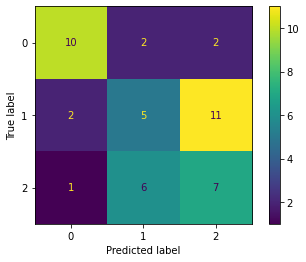

              precision    recall  f1-score   support

           0       0.77      0.71      0.74        14
           1       0.38      0.28      0.32        18
           2       0.35      0.50      0.41        14

    accuracy                           0.48        46
   macro avg       0.50      0.50      0.49        46
weighted avg       0.49      0.48      0.48        46

RESULTADOS CNN criada


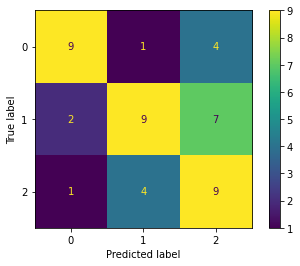

              precision    recall  f1-score   support

           0       0.75      0.64      0.69        14
           1       0.64      0.50      0.56        18
           2       0.45      0.64      0.53        14

    accuracy                           0.59        46
   macro avg       0.61      0.60      0.59        46
weighted avg       0.62      0.59      0.59        46

[INFO] The single image prediction result is class:  [2]


In [43]:
def prediction_pipiline(image, model_path, thresh=0.6):
    model = load_model(model_path)
    image = np.expand_dims(image, axis=0)
    y_res = model.predict(image)
    if np.max(y_res) < thresh:
      return 'Unknow Class'
    else:
      return np.where(y_res[0]==max(y_res[0]))[0]

def test_model(model_path,X_test,y_test):
    model = load_model(model_path)
    y_res = model.predict(X_test)
    y_pred = [np.where(y==max(y))[0] for y in y_res]
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    print(classification_report(y_test,y_pred))

print("RESULTADOS MOBILENET")
test_model('/content/mobile_car_classifier.h5',X_test,y_test)

print("RESULTADOS CNN criada")
test_model('/content/cnn_car_classifier.h5',X_test,y_test)

print("[INFO] The single image prediction result is class: ",prediction_pipiline(X_test[30][:],'/content/mobile_car_classifier.h5'))